# Модель машинного обучения соревнования на kaggle при помощи catboost
Regression with an Abalone Dataset
## Цели
- подбор параметров

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

In [2]:
# загрузка даных
df = pd.read_csv('data/train.csv')
df_pred = pd.read_csv('data/test.csv')

df_abalone = pd.read_csv('data/abalone.csv')

## Подготовка данных

In [3]:
# привожу название признаков к единому виду
df_abalone.rename(columns={'Shucked weight': 'Whole weight.1',
                           'Viscera weight': 'Whole weight.2'}, inplace=True)

In [4]:
# удаляю id
df.drop(columns='id', inplace=True)
df_pred.drop(columns='id', inplace=True)

In [5]:
df_all = pd.concat([df, df_abalone], ignore_index=True)

In [6]:
df_all = pd.get_dummies(df_all, columns=['Sex'], prefix='Sex')
df_all[['Sex_F','Sex_M','Sex_I']] = df_all[['Sex_F','Sex_M','Sex_I']].astype(int)

df_pred = pd.get_dummies(df_pred, columns=['Sex'], prefix='Sex')
df_pred[['Sex_F','Sex_M','Sex_I']] = df_pred[['Sex_F','Sex_M','Sex_I']].astype(int)

In [7]:
# убераю пробелы в названиях столбцов
new_columns = {'Whole weight.1': 'Whole_weight.1',
               'Whole weight.2': 'Whole_weight.2',
               'Whole weight': 'Whole_weight',
               'Shell weight': 'Shell_weight'}
df_all.rename(columns=new_columns, inplace=True)
df_pred.rename(columns=new_columns, inplace=True)

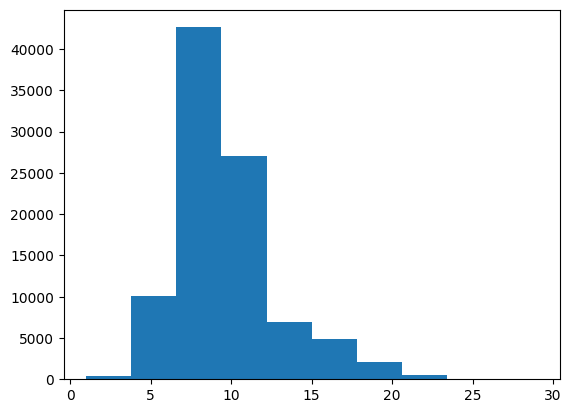

In [8]:
plt.hist(df_all.Rings);

In [9]:
# Применение логарифмического преобразования
df_all['Rings'] = np.log(df_all['Rings'])

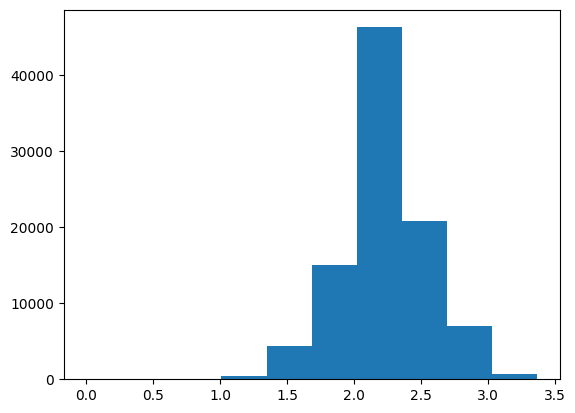

In [10]:
plt.hist(df_all.Rings);

In [11]:
df_all.corr()

,Length,Diameter,Height,Whole_weight,Whole_weight.1,Whole_weight.2,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
Length,1.000000,0.989600,0.911599,0.931092,0.908951,0.912522,0.910372,0.719251,0.363100,-0.651890,0.312119
Diameter,0.989600,1.000000,0.915261,0.933384,0.907634,0.913825,0.917211,0.729223,0.368470,-0.660468,0.315658
Height,0.911599,0.915261,1.000000,0.898076,0.857288,0.881601,0.899585,0.732337,0.364173,-0.639265,0.298303
Whole_weight,0.931092,0.933384,0.898076,1.000000,0.971160,0.973909,0.963767,0.671091,0.365693,-0.646884,0.304563
Whole_weight.1,0.908951,0.907634,0.857288,0.971160,1.000000,0.948351,0.910346,0.582485,0.339297,-0.614723,0.297297
Whole_weight.2,0.912522,0.913825,0.881601,0.973909,0.948351,1.000000,0.935596,0.646042,0.367843,-0.642262,0.297820
Shell_weight,0.910372,0.917211,0.899585,0.963767,0.910346,0.935596,1.000000,0.732408,0.369057,-0.643490,0.297900
Rings,0.719251,0.729223,0.732337,0.671091,0.582485,0.646042,0.732408,1.000000,0.318511,-0.565855,0.267731
Sex_F,0.363100,0.368470,0.364173,0.365693,0.339297,0.367843,0.369057,0.318511,1.000000,-0.486597,-0.465927
Sex_I,-0.651890,-0.660468,-0.639265,-0.646884,-0.614723,-0.642262,-0.643490,-0.565855,-0.486597,1.000000,-0.546287


In [12]:
df_all

,Length,Diameter,Height,Whole_weight,Whole_weight.1,Whole_weight.2,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,2.397895,1,0,0
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,2.397895,1,0,0
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,1.791759,0,1,0
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,2.302585,0,0,1
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,2.197225,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
94787,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,2.397895,1,0,0
94788,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,2.302585,0,0,1
94789,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,2.197225,0,0,1
94790,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,2.302585,1,0,0


## Поиск гиперпараметров

In [13]:
X = df_all.drop(columns='Rings')
y = df_all['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
# def objective(trial: optuna.Trial):
#     '''
#     Обычная сигнатура функции оптимизации для optuna.
#     '''
#     params = {
#         'random_seed': 42,
#         'verbose': 0,
#         'eval_metric': 'MSLE',
#         'iterations': trial.suggest_int('iterations', 1000, 2100),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#         'depth': trial.suggest_int('depth', 3, 12),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
#         # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
#         # 'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True)
#     }
    
#     model = CatBoostRegressor(**params)
#     model.fit(X_train, y_train, eval_set=(X_test, y_test))
#     predictions = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(predictions)))
    
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=300)

In [15]:
# study.best_params

In [16]:
best_params = {'iterations': 1778,
               'learning_rate': 0.09987328200297617,
               'l2_leaf_reg': 2.865790596985585,
               'depth': 6,
               'random_seed': 42,
               'verbose': 0,
               'eval_metric': 'MSLE'
              }

## Модель
- kaggle public Score: 0.14664 - обучение на всей выборке

In [17]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.exp(y_true), np.exp(y_pred)))

In [18]:
cat_model = CatBoostRegressor(**best_params)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)
rmsle_cat = rmsle(y_test, y_pred_cat)
pred = cat_model.predict(df_pred)
rmsle_cat

0.14869915424998625

In [19]:
cat_model = CatBoostRegressor(**best_params)
cat_model.fit(X, y)
pred = cat_model.predict(df_pred)

In [20]:
df_pred_duble = pd.read_csv('data/test.csv')
df_pred_Id = df_pred_duble['id']

output = pd.DataFrame({'id': df_pred_Id, 'Rings': pred})
output.Rings = np.exp(output.Rings)
output.to_csv('data/cat_model.csv', index=False)